<a href="https://colab.research.google.com/github/GalaIvannikova/Diploma_Alcohol-Consumption-in-Russia/blob/master/Diploma_Alcohol_Consumption_in_Russia_(1998_2016).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diploma Alcohol Consumption in Russia (1998-2016)

In [ ]:
pip install git+git://github.com/geopandas/geopandas.git

In [10]:
# Подключаем основную библиотеку для работы с данными
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu
import geopandas as gpd

**Контекст**

Набор данных по Потреблению алкоголя в России за 1998-2016 годы. Датасет содержит значения о потреблении вина, пива, водки, бренди и шампанского.

**Данные**

Датасет содержит 1615 строк и 7 столбцов. 
Основные столбцы:
*   "year" - годы (1998-2016)
*   "region" - название федерального субъекта Российской Федерации. Это может быть область, республика, край, автономный округ, город федерального значения или автономная область.
* "wine" - продажи вина в литрах в год на душу населения
* "beer" - продажи пива в литрах в год на душу населения
* "vodka" - продажи водки в литрах в год на душу населения
* "champagne" - продажи шампанского в литрах в год на душу населения
* "brandy" - продажи бренди в литрах в год на душу населения

# Загрузим датасет и посмотрим на исходные данные

In [72]:
# Загружаем данные из файла
#Ссылка на файл - https://www.dropbox.com/s/mwu378e3674ruh6/russia_alcohol.csv?dl=0
df = pd.read_csv('russia_alcohol.csv')

In [71]:
# Выводим первые 5 строк датасета
df.head()

,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2


In [13]:
# Посмотрим информацию по датасету
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       1615 non-null   int64  
 1   region     1615 non-null   object 
 2   wine       1552 non-null   float64
 3   beer       1557 non-null   float64
 4   vodka      1554 non-null   float64
 5   champagne  1552 non-null   float64
 6   brandy     1549 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 88.4+ KB


* Первый столбец записан в числовом формате  int64.
* Столбец region представлена форматом object.
* Остальные столбцы - числовые с плавающей запятой.
* Как видно из количества заполненных строк, не по всем напиткам есть одинаковое количество данных. В данных есть пропуски.

# Поиск пропусков данных

Найдем какие данные пропущенны, чтобы принять решение о работе с пропусками.

In [14]:
# Для начала сделаем группировку по годам
df.groupby('year').count()

# Всего в анализе участвуют данные за 19 лет с 1998 по 2016 года.

,region,wine,beer,vodka,champagne,brandy
year,,,,,,
1998,85,81,81,81,81,81
1999,85,81,81,81,81,81
2000,85,81,81,81,81,81
2001,85,82,82,82,82,82
2002,85,82,82,82,82,82
2003,85,82,82,82,82,82
2004,85,82,82,82,82,82
2005,85,82,82,82,82,81
2006,85,82,82,82,82,81


В столбцах с типами напитков равномерно отсутствуют данные за каждый год. Гипотеза: нехватает данных по определенным регионам. Если это так, то эти регионы можно либо исключить из анализа, либо присвоить им среднее значение по стране.

In [15]:
# Посмотрим на результаты при крупировки по регионам. Нас интересуют только те регионы, в которых количество строк меньше 19.
df_null_region = df.groupby('region').count()
df_null_region[(df_null_region['wine'] < 19) | (df_null_region['beer'] < 19) | (df_null_region['vodka'] < 19) | (df_null_region['champagne'] < 19) | (df_null_region['brandy'] < 19)]

,year,wine,beer,vodka,champagne,brandy
region,,,,,,
Chechen Republic,19,0,3,0,0,0
Republic of Crimea,19,3,3,3,3,3
Republic of Ingushetia,19,7,9,9,7,4
Sevastopol,19,3,3,3,3,3


Данные отсутствуют по 4 регионам. При этом в Республике Ингушетия по некоторым категориям напитков почти за половину лет. По остальным регионам отсутствуют данные всего за 3-4 года.

Данные по Республике Ингушетия лучше исключить из общего анализа. При необходимости, можно рассмотреть этот региона отдельно исходя из имеющихся данных.

По остальным регионам можно заменить отсутствующие значения средними значениями для данного региона по данному типу напитка.

# Основные статистические показатели и среднее

In [16]:
# Посмотрим на основные статистические показатели нашего датасета.
df.describe()

,year,wine,beer,vodka,champagne,brandy
count,1615.000000,1552.000000,1557.000000,1554.000000,1552.000000,1549.000000
mean,2007.000000,5.628144,51.260148,11.818694,1.313177,0.526998
std,5.478922,2.813208,25.372821,5.128806,0.797956,0.400201
min,1998.000000,0.100000,0.400000,0.050000,0.100000,0.000000
25%,2002.000000,3.575000,32.400000,8.300000,0.800000,0.200000
50%,2007.000000,5.400000,49.970000,11.500000,1.200000,0.400000
75%,2012.000000,7.377500,67.400000,15.000000,1.665000,0.700000
max,2016.000000,18.100000,207.300000,40.600000,5.560000,2.300000


Так как средние значения не сильно отличаются от значений второго процентиля (50%), заполним пустые значения средними данными по региону на основе остальных лет.

In [17]:
# Отфильтруем данные, исключив из них данные о Республике Ингушетия

df_filter = df[df['region'] != 'Republic of Ingushetia']
df_filter.head(10)

,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2
5,1998,Republic of Bashkortostan,1.8,17.5,10.7,0.9,0.2
6,1998,Belgorod Oblast,3.4,23.0,10.8,0.9,0.1
7,1998,Bryansk Oblast,3.4,32.4,9.7,0.5,0.1
8,1998,Republic of Buryatia,1.1,8.8,15.8,0.9,0.1
9,1998,Vladimir Oblast,1.5,16.6,16.8,0.5,0.1


In [18]:
# Найдем среднее по России потребление напитка для каждого года по отдельности.
df_mean = df_filter.groupby('year').mean().reset_index()
df_mean.head(20)

,year,wine,beer,vodka,champagne,brandy
0,1998,3.029630,20.419753,12.669136,0.913580,0.228889
1,1999,3.120988,25.395062,13.469136,0.846914,0.210864
2,2000,3.343210,30.130864,13.572840,0.892593,0.233704
3,2001,3.864198,36.675309,14.365432,0.927160,0.260494
4,2002,4.364198,42.791358,14.917284,0.969136,0.314815
5,2003,5.174074,47.849383,14.640741,1.038272,0.361728
6,2004,5.760494,53.045679,14.466667,1.097531,0.387654
7,2005,6.041975,55.160494,13.833333,1.185185,0.411111
8,2006,5.856790,62.285185,13.235802,1.230864,0.437037
9,2007,6.703704,62.764198,12.479012,1.422222,0.534568


Мы получили среднее потребление каждого типа напитка по годам. Для наглядности можно нарисовать диаграмму.

# Среднее потребление на душу населения по стране в целом по типам напитков

In [19]:
# Создаю nampy array для оси Х со списком лет
np_years = np.array(df_mean['year'])
np_years

array([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

In [20]:
# Создаю nampy array для оси Y со списками значений по категориям напитков
np_wine_mean = np.array(df_mean['wine'])
np_beer_mean = np.array(df_mean['beer'])
np_vodka_mean = np.array(df_mean['vodka'])
np_champagne_mean = np.array(df_mean['champagne'])
np_brandy_mean = np.array(df_mean['brandy'])

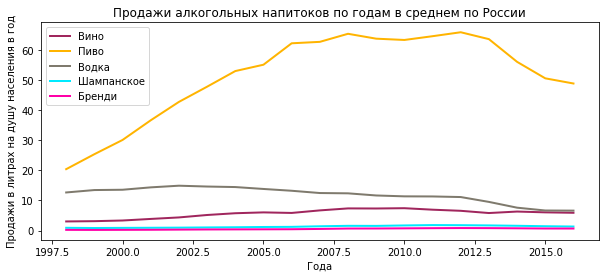

In [21]:
# Задаем данные по годам, в качестве оси X и данные по разным видам напитков по оси Y.
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(np_years, np_wine_mean, '#a0265d', linewidth=2, label='Вино')
ax.plot(np_years, np_beer_mean, '#ffb400', linewidth=2, label='Пиво')
ax.plot(np_years, np_vodka_mean, '#7f7a6d', linewidth=2, label='Водка')
ax.plot(np_years, np_champagne_mean, '#00eaff', linewidth=2, label='Шампанское')
ax.plot(np_years, np_brandy_mean, '#ff00a8', linewidth=2, label='Бренди')

ax.set_title('Продажи алкогольных напитоков по годам в среднем по России')
ax.set_xlabel('Года')
ax.set_ylabel('Продажи в литрах на душу населения в год')
ax.legend()
 
plt.show()

На одном графике можно увидеть основные тренды, но, чтобы получить более детальную информацию, рассмотрим каждый вид напитка в отдельности.

**График потребления вина в целом по России**

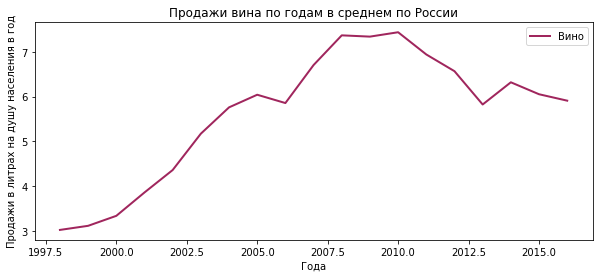

In [22]:
# Оставляем на графике только данные из категории вино
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(np_years, np_wine_mean, '#a0265d', linewidth=2, label='Вино')

ax.set_title('Продажи вина по годам в среднем по России')
ax.set_xlabel('Года')
ax.set_ylabel('Продажи в литрах на душу населения в год')
ax.legend()
 
plt.show()

Самый низкое потребление вина зафиксировано в начале отчетного периода - 3,03 литра в год на душу населения.
После чего был стабильный рост потребления до 2010 года, когда объем вырос до 7,43 литров в год на душу населения.
После чего начался период снижения потребления, но в целом, значения последних лет близки к среднему показателю за весь период - 5,6 литров в год на душу населения.

Проверим U-критерием Манна — Уитни для несвязанных выборок гипотезу о том, что потребление вина в первой и второй половине отчетного периода различаются.

In [23]:
data1 = np_wine_mean[:9]
data2 = np_wine_mean[9:]
stat, p = mannwhitneyu(data1, data2)
print("Mann-Whitney U =", stat)
print("p-value =", p)

Mann-Whitney U = 3.0
p-value = 0.0003514303595517608


Значение p-value < 0.05 говорит о том, что выборки отличаются и данное отличие является статистически значимым.

**График потребления пива в целом по России**

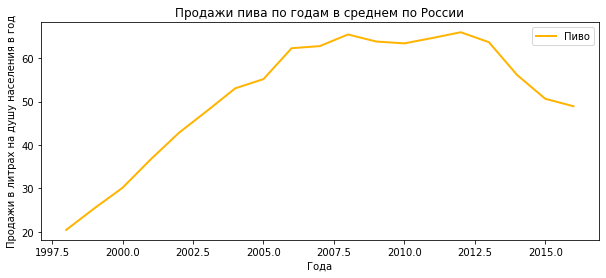

In [24]:
# Оставляем на графике только данные из категории пиво
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(np_years, np_beer_mean, '#ffb400', linewidth=2, label='Пиво')

ax.set_title('Продажи пива по годам в среднем по России')
ax.set_xlabel('Года')
ax.set_ylabel('Продажи в литрах на душу населения в год')
ax.legend()
 
plt.show()

Потребление пива за отчетный период выросло в несколько раз с 20,4 литров на душу населения в 1998 году, достигло максимума к 2012 году - 66 литров на человека в год. Дальше график идет на снижение и в 2016 году зафиксировано 49 литров в год на душу населения.

**Гипотеза**

В первой половине отчетного периода количества потребления пива на душу населения отличается от второй половины. 
Проверим данную гипотезу тестом для несвязанных небольших выборок данных U-критерием Манна — Уитни.

In [25]:
data1 = np_beer_mean[:9]
data2 = np_beer_mean[9:]
stat, p = mannwhitneyu(data1, data2)
print("Mann-Whitney U =", stat)
print("p-value =", p) 

Mann-Whitney U = 7.0
p-value = 0.001099823530556528


Так как значения p-value значительно меньше 0,05, то можно сделать вывод о том, что различия выборок являются статистически значимыми.

**График потребления водки в целом по России**

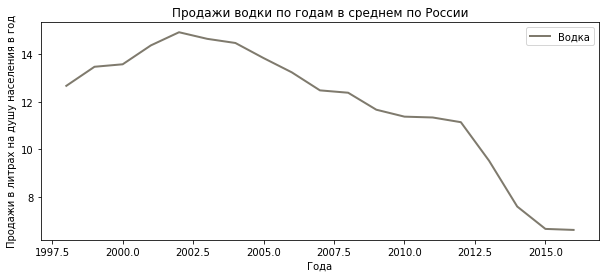

In [26]:
# Оставляем на графике только данные из категории водка
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(np_years, np_vodka_mean, '#7f7a6d', linewidth=2, label='Водка')

ax.set_title('Продажи водки по годам в среднем по России')
ax.set_xlabel('Года')
ax.set_ylabel('Продажи в литрах на душу населения в год')
ax.legend()
 
plt.show()

Как видно на графике, потребление водки на душу населения в России в последние годы стабильно сокращается.

И, хотя, в первые годы отчетного периода был зафиксирован небольшой рост, после 2002 года происходит стабильное снижение потребление водки. Если в 1998 году потребление составляло  12,7 литров на человека в год, то к 2016 году оно достигло 6,6 литров на душу населения в год, то есть стало в 2 раза меньше.

К 2016 году потребление водки и вина в России на душу населения практически сровнялось: 6,6 литров водки и 5,9 литров вина.

Посмотрим, является ли разница в потреблении водки в первой и второй половинах отчетного периода статистически значимой.

In [27]:
data1 = np_vodka_mean[:9]
data2 = np_vodka_mean[9:]
stat, p = mannwhitneyu(data1, data2)
print("Mann-Whitney U =", stat)
print("p-value =", p) 

Mann-Whitney U = 0.0
p-value = 0.00013985013509334326


Так как значение p-value = 0,1% или значительно меньше 0,05, при этом U-критерий Манна — Уитни = 0. Следовательно гипотеза не верна и выборки статистически не различаются и это можно утверждать с высокой долей вероятности.

**График потребления шампанского в целом по России**

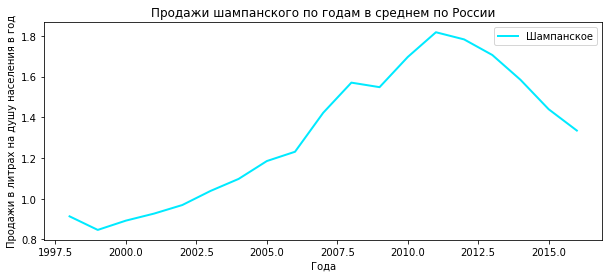

In [28]:
# Оставляем на графике только данные из категории шампанское
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(np_years, np_champagne_mean, '#00eaff', linewidth=2, label='Шампанское')

ax.set_title('Продажи шампанского по годам в среднем по России')
ax.set_xlabel('Года')
ax.set_ylabel('Продажи в литрах на душу населения в год')
ax.legend()
 
plt.show()

Шампанское в России является менее популярным напитком, чем водка, пиво или вино и его потребление в разы ниже потребления ранее рассмотренных напитков.

Тем не менее за отчетный период потребление шампанского в России выросло с 0,9 литров на душу населения в 1998 до 1,3 литров в 2016 году. При этом пик, так же как с потреблением пива, приходится на 2011-2012 годы - 1,8 литров на человека в год.

Посмотрим, является ли различие в потреблении статистически значимым.

In [29]:
data1 = np_champagne_mean[:9]
data2 = np_champagne_mean[9:]
stat, p = mannwhitneyu(data1, data2)
print("Mann-Whitney U =", stat)
print("p-value =", p) 

Mann-Whitney U = 0.0
p-value = 0.00013985013509334326


Значение p-value = 0.01%, при этом U-критерий Манна — Уитни = 0, из чего следует вывод, что с высокой долей вероятности можно сделать вывод о том, что в первой и второй половине отчетного периода потребление шампанского статистистически не различалось.

**График потребления бренди в целом по России**

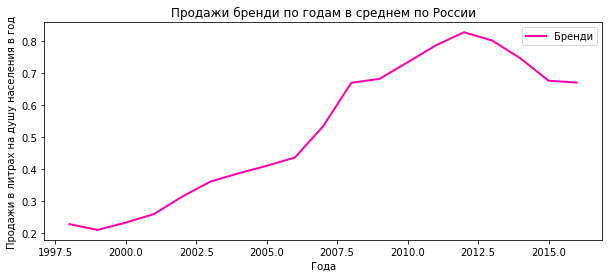

In [30]:
# Оставляем на графике только данные из категории бренди
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(np_years, np_brandy_mean, '#ff00a8', linewidth=2, label='Бренди')

ax.set_title('Продажи бренди по годам в среднем по России')
ax.set_xlabel('Года')
ax.set_ylabel('Продажи в литрах на душу населения в год')
ax.legend()
 
plt.show()

Так же как и по другим напиткам, потребление бренди за отчетный период значительно выросло. 

В 1998 году на душу населения приходилось 0,23 литра бренди в год, а в 2016 - 0,67 литра. Пик опять же приходится на 2012 год, когда потребление достигло 0,83 литра на человека в год.

Тем не менее, можно заметить, что потребление бренди близко к потреблению шампанского и сильно меньше, чем потребление вина, водки или пива. 

In [31]:
data1 = np_brandy_mean[:9]
data2 = np_brandy_mean[9:]
stat, p = mannwhitneyu(data1, data2)
print("Mann-Whitney U =", stat)
print("p-value =", p) 

Mann-Whitney U = 0.0
p-value = 0.00013985013509334326


Расчет U-критерия Манна — Уитни показал, что статистически между выборками нет значительной разницы и результат можно считать статистически достоверным, так как p-value < 0,05.

**Выводы по потреблению алкоголя по России в целом**
1. Утверждение иностранцев, что в России пьют исключительно водку - не верно. Водку пьют, но ее потребление с течением времени сокращается.
2. Потребление пива на душу населения в 3-6 раз превышает потребление других алкогольных напитков.
3. С ростом благостостояния страны увеличивается количество потребления вина и сокращается потребление водки. При этом значительных изменений в потреблении шампанского и бренди на происходит.
4. В начале 2000-х годов произошел резкий всплеск потребления пива на душу населения. Пик пришелся на 2007-2012 годы, после чего начался спад. Потребление увеличилось в 3 раза относительно 1998 года. Гипотеза. Резкий рост потребления пива произошел благодаря развитию технологий и открытию частных пивоварен. Модой на крафтовое пиво и повсеместным открытием магазинов разливного пива. Выбор стал больше и пиво стало пить интереснее. Возможно, также сказалось улучшение благостостояния населения и появилось больше свободных средств, которые можно потратить на не первоочередные нужды. Плюс также мог сыграть роль культурный аспект и перенос встреч с друзьями из дома в бары, развитие барной культуры в России. Можно строить различные гипотезы, но для их проверки требуется большее количество специфических данных.
5. На графиках ясно прослеживается обратная динамика потребления водки, относительно других напитков. Только потребление водки сокращается, при этом потребление других алкогольных напитков в стране растет. Так к 2016 году на душу населения приходится примерно одинаковое количества вина и водки: 5,9 литров вина и 6,6 литров водки в год.

## Заполним пропуски данных средними значениями для данного региона

Заполним пропуски данных средними значениями по данному региону России для данного типа напитка.

In [32]:
df_region_mean = df_filter.groupby('region').mean()

for drink in ['wine', 'beer', 'vodka', 'champagne', 'brandy']:
      df_filter.loc[df_filter[drink].isna(), drink] = df_filter.loc[df_filter[drink].isna(), 'region'].apply(lambda reg: df_region_mean.loc[reg, drink])

df_filter.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2


## Топ регионов по потреблению алкогольных напитков

**ТОП 5 регионов по потреблению вина на душу населения**

In [33]:
wine_region = pd.pivot_table(df_filter, values='wine', index='region', columns='year', aggfunc='sum')

wine_region.sort_values(by=1998, ascending=False).head(5).style.applymap(lambda x: "background-color: #e65a71" if x>df_region_mean['wine'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Stavropol Krai,8.800000,5.900000,6.400000,5.900000,6.000000,6.100000,6.200000,6.800000,7.300000,6.800000,6.800000,6.400000,5.400000,5.970000,5.500000,4.500000,4.800000,3.900000,3.800000
Krasnodar Krai,8.500000,6.800000,7.000000,6.600000,7.900000,8.700000,8.800000,8.900000,8.300000,8.200000,8.700000,7.800000,6.700000,6.470000,5.700000,5.100000,5.600000,5.600000,5.300000
Moscow,6.800000,6.600000,6.300000,5.000000,4.800000,6.200000,6.100000,6.400000,5.900000,7.300000,8.400000,9.400000,10.100000,9.850000,9.700000,8.800000,8.500000,7.500000,6.600000
Kamchatka Krai,6.400000,6.500000,7.100000,7.400000,7.300000,7.400000,7.500000,8.600000,8.000000,7.800000,7.200000,7.600000,7.700000,7.590000,7.500000,6.700000,6.400000,7.000000,6.600000
Magadan Oblast,6.200000,4.800000,4.300000,4.700000,4.000000,4.800000,5.900000,6.700000,6.600000,7.300000,8.100000,8.800000,7.900000,8.170000,8.000000,6.800000,7.700000,8.200000,7.600000


В 1998 году первое место по потреблению вина занял
1. Ставрапольский Край со значением 8,8 литров на душу населения.
2. На втором месте - Краснодарский край - 8,5 литров.
3. Москва - 6,8 литров.
4. Камчатка - 6,4 литра
5. Магаданская область - 6,2 литра.

Как видно из таблицы, с течением времени том регионов менялся и к 2016 году первенство заняли другие регионы.

In [34]:
wine_region = pd.pivot_table(df_filter, values='wine', index='region', columns='year', aggfunc='sum')

wine_region.sort_values(by=2016, ascending=False).head(5).style.applymap(lambda x: "background-color: #e65a71" if x>df_region_mean['wine'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Nenets Autonomous Okrug,4.300000,4.600000,5.500000,7.000000,8.100000,9.200000,7.000000,7.600000,8.600000,10.100000,10.700000,11.300000,12.000000,10.530000,9.900000,8.400000,11.400000,12.800000,11.700000
Republic of Karelia,3.200000,2.400000,2.800000,5.100000,9.300000,13.500000,16.900000,15.000000,14.700000,11.900000,14.300000,13.600000,12.900000,11.980000,10.600000,10.800000,12.300000,11.700000,11.500000
Novgorod Oblast,4.100000,4.900000,4.600000,4.600000,5.000000,5.500000,5.900000,6.100000,6.400000,12.100000,14.500000,14.800000,14.800000,13.710000,13.100000,11.300000,12.000000,10.500000,10.600000
Pskov Oblast,1.800000,6.100000,7.100000,9.600000,10.300000,13.500000,17.500000,12.800000,11.800000,10.200000,9.500000,10.300000,13.600000,12.750000,9.500000,7.300000,12.100000,9.700000,10.400000
Yaroslavl Oblast,3.500000,3.600000,3.500000,4.300000,4.500000,3.800000,3.900000,5.500000,5.700000,9.700000,10.400000,10.000000,11.300000,10.270000,9.700000,7.600000,9.900000,9.300000,10.200000


ТОП 5 регионов по потреблению вина на душу населения в 2016 году выглядит так:
1. Ненецкий автономный округ - 11,7 литров
2. Карелия - 11,5 литров
3. Новгородская область - 10,6 литров
4. Псковская область - 10,4 литра
5. Ярославская область - 10,2 литра

Если в 1998 году первые места по потреблению вина занимают южные регионы страны, для которых производства вина является традиционной областью хозяйства, то к 2016 потребление вина смещается на север. 

Возможно, смещение винных регионов связано с повышением уровня благосостояния населения, улучшением поставок вина в такие регионы как Карелия и Ненецкий автономный округ. При этом за отчетный период потребление вина в южных регионах страны сократилось практически в два раза.

In [35]:
wine_region = pd.pivot_table(df_filter, values='wine', index='region', columns='year', aggfunc='sum')

wine_region.sort_values(by=1998, ascending=True).head(5).style.applymap(lambda x: "background-color: #97ca9b" if x<df_region_mean['wine'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Chechen Republic,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Chukotka Autonomous Okrug,0.300000,0.400000,1.000000,1.400000,1.900000,3.800000,3.400000,4.000000,5.500000,6.300000,8.400000,4.900000,5.500000,5.230000,5.100000,4.000000,9.600000,4.700000,3.900000
Primorsky Krai,0.600000,1.200000,1.800000,1.500000,1.600000,1.700000,2.800000,5.200000,4.600000,4.900000,5.300000,5.600000,5.500000,6.030000,6.700000,5.900000,6.700000,6.200000,6.800000
Zabaykalsky Krai,0.900000,1.100000,1.900000,3.500000,4.700000,5.900000,15.700000,16.300000,13.700000,6.700000,6.900000,6.500000,6.400000,6.520000,6.600000,6.400000,6.600000,6.600000,6.400000
Ulyanovsk Oblast,1.000000,1.100000,0.800000,1.100000,2.100000,4.100000,5.500000,5.200000,4.500000,5.300000,6.800000,6.400000,7.000000,7.410000,6.600000,5.300000,6.400000,7.600000,6.600000


ТОП 5 регионов с наименьшим потреблением вина в 1998 выглядел так:
1. Чечня - 0 литров
2. Чукотка - 0,3 литра
3. Приморский край - 0,6 литров
4. Забайкальский край - 0,9 литра
5. Ульяновскаая область - 1 литр на человека в год

На Дальнем Востоке в 1998 году вино не пользовалось популярностью.

Посмотрим, как изменилась картина к 2016 году.

In [36]:
wine_region = pd.pivot_table(df_filter, values='wine', index='region', columns='year', aggfunc='sum')

wine_region.sort_values(by=2016, ascending=True).head(5).style.applymap(lambda x: "background-color: #97ca9b" if x<df_region_mean['wine'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Chechen Republic,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Republic of Dagestan,4.800000,3.800000,3.800000,4.600000,2.700000,2.900000,2.800000,2.400000,2.900000,2.400000,3.100000,3.800000,3.300000,3.270000,1.600000,1.000000,0.400000,0.400000,0.100000
Republic of North Ossetia-Alania,1.400000,1.700000,2.600000,5.600000,1.000000,0.200000,2.300000,2.200000,2.500000,2.500000,1.900000,1.500000,1.700000,1.720000,1.400000,1.300000,0.600000,0.500000,0.500000
Kabardino-Balkar Republic,1.600000,1.800000,2.500000,2.700000,3.700000,4.400000,4.000000,3.300000,2.500000,2.900000,3.400000,3.200000,3.200000,2.660000,1.700000,0.800000,0.500000,0.600000,0.600000
Karachay-Cherkess Republic,1.700000,2.100000,2.200000,2.300000,2.700000,3.700000,4.200000,4.600000,3.000000,2.000000,1.900000,1.500000,1.400000,1.360000,1.300000,1.100000,1.200000,1.100000,0.900000


В 2016 году самым не пьющим вино регионом остается Чечня. Топ 5 стран выглядит так:
1. Чечня - 0 литров
2. Дагестан - 0,1 литров
3. Северная Осетия - 0,5 литров
4. Кабардино-Балкария - 0,6 литров
5. Карачаево-Черкесия - 0,9 литров

Интересно, что, если в 1998 году Дагестан показывал результаты, в целом, близкие к средним значениям по России, то к 2016 году потребление вина в регионе постепенно сокращалось и сошло практически на нет. В Чечне стабильно не употребляют вино.

**ТОП 5 регионов по потреблению пива на душу населения**

In [37]:
beer_region = pd.pivot_table(df_filter, values='beer', index='region', columns='year', aggfunc='sum')

beer_region.sort_values(by=1998, ascending=False).head(5).style.applymap(lambda x: "background-color: #e65a71" if x>df_region_mean['beer'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Omsk Oblast,42.100000,36.000000,41.500000,55.500000,84.200000,97.300000,26.600000,28.200000,30.400000,104.200000,126.300000,116.700000,118.800000,126.930000,125.200000,103.000000,79.700000,60.400000,53.200000
Republic of Khakassia,38.300000,48.700000,47.900000,53.600000,56.300000,61.200000,74.500000,73.600000,90.100000,73.100000,54.600000,58.500000,57.700000,68.000000,70.300000,68.600000,82.200000,84.300000,79.100000
Smolensk Oblast,35.600000,53.800000,55.300000,71.300000,96.200000,92.300000,84.500000,78.900000,66.200000,62.800000,60.700000,57.400000,54.200000,57.030000,58.300000,56.100000,55.500000,51.800000,48.000000
Ulyanovsk Oblast,34.800000,46.300000,46.100000,47.700000,44.800000,42.500000,45.300000,32.600000,49.500000,52.800000,41.100000,39.900000,40.000000,54.900000,54.600000,55.200000,47.600000,46.600000,46.900000
Magadan Oblast,33.800000,18.700000,24.600000,28.300000,33.000000,43.200000,39.400000,40.200000,42.400000,42.000000,34.200000,41.500000,55.500000,55.400000,59.900000,61.600000,63.500000,59.800000,56.500000


ТОП регионов с наибольшим потреблением пива в 1998 году выглядел так:
1. Омская область - 42.2 литра
2. Республика Хакасия - 38.3 литра
3. Смоленская область - 35.6 литров
4. Ульяновская область - 34.8 литров
5. Магаданская область - 33.8 литров
При этом интересен не равномерный рост количества потребления пива по отдельным регионам от года к году.

К примеру, хотя Омская область заняла первое место по потреблению пива в 1998 году, это значение ниже среднего значения по потреблению пива за весь период времени. Так же виден резкий скачок по потреблению пива в данном регионе в 2002-2003 годах и далее такой же резкий спад в 2004-2006 годах. 
Данные по Омской области:
* 1998 - 42.1 литр на душу населения в год
* 1999 - 36 литров
* 2000 - 41.5 литр
* 2001 - 55.5 литров
* 2002 - 84.2 литра
* 2003 - 97.3 литра
* 2004 - 26.6 литров

Возможно, данная разница произошла из-за разной методики подсчетов, либо по внешней причине. 

In [38]:
beer_region = pd.pivot_table(df_filter, values='beer', index='region', columns='year', aggfunc='sum')
beer_region.sort_values(by=2016, ascending=False).head(5).style.applymap(lambda x: "background-color: #e65a71" if x>df_region_mean['beer'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Moscow Oblast,11.900000,15.800000,22.600000,23.700000,29.400000,29.600000,30.500000,32.300000,38.700000,67.400000,86.000000,100.600000,100.600000,108.640000,101.000000,99.000000,97.700000,94.900000,99.100000
Kamchatka Krai,25.500000,30.600000,32.700000,33.600000,35.300000,39.100000,49.200000,50.500000,69.100000,69.600000,73.400000,75.000000,75.600000,77.770000,76.000000,76.300000,76.000000,81.200000,85.400000
Republic of Khakassia,38.300000,48.700000,47.900000,53.600000,56.300000,61.200000,74.500000,73.600000,90.100000,73.100000,54.600000,58.500000,57.700000,68.000000,70.300000,68.600000,82.200000,84.300000,79.100000
Yamalo-Nenets Autonomous Okrug,23.800000,34.400000,36.900000,49.000000,77.000000,93.300000,94.500000,101.100000,106.600000,95.400000,93.400000,86.600000,87.400000,100.920000,99.900000,97.700000,86.200000,82.700000,75.800000
Khabarovsk Krai,24.800000,30.000000,31.900000,38.400000,31.800000,47.400000,53.400000,70.500000,85.700000,93.700000,99.600000,94.700000,101.400000,104.940000,98.200000,94.300000,90.900000,68.300000,73.700000


К 2016 году ТОП 5 регионов по потреблению пива на душу населения выглядел так:
1. Московская область - 99.1 литров
2. Камчатка - 85.4 литров
3. Республика Хакасия - 79.1 литров
4. Ямало-Ненецкий АО - 75.8 литра
5. Хабаровский край - 73.7 литра

По сравнению с 1998 годом общее количество потребления пива выросло в среднем в 3 раза. При этом топ регионов изменился. По прежнему в лидерах потребления пива осталась только Хакасия, сместившись со 2 на 3 место. Остальные регионы изменились.

Москва входит в топ российских регионов по потреблению пива только с 2007 года, а до этого времени показетили потребления там были ниже среднего значения по России. 

In [39]:
beer_region = pd.pivot_table(df_filter, values='beer', index='region', columns='year', aggfunc='sum')

beer_region.sort_values(by=1998, ascending=True).head(5).style.applymap(lambda x: "background-color: #97ca9b" if x<df_region_mean['beer'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Chukotka Autonomous Okrug,1.800000,2.300000,5.200000,11.000000,6.400000,12.300000,10.800000,9.100000,11.000000,12.700000,16.700000,9.800000,17.700000,16.910000,24.000000,27.000000,32.700000,31.500000,34.000000
Chechen Republic,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,4.900000,2.200000,1.200000
Republic of Dagestan,3.800000,1.600000,1.800000,3.300000,9.600000,9.700000,6.600000,10.400000,6.900000,5.900000,6.600000,6.300000,3.100000,2.740000,2.500000,2.100000,2.200000,2.100000,1.000000
Republic of Kalmykia,4.100000,5.200000,9.100000,13.900000,20.900000,24.400000,24.400000,25.100000,34.000000,29.300000,24.900000,26.800000,24.300000,17.900000,15.900000,13.600000,17.400000,19.600000,20.300000
Karachay-Cherkess Republic,5.400000,6.900000,7.400000,9.400000,13.200000,14.900000,19.600000,20.900000,22.100000,23.000000,27.800000,29.100000,28.400000,29.530000,28.700000,28.100000,28.100000,28.900000,25.300000


ТОП 5 регионов с наименьшим потреблением пива в 1998 выглядел так:
1. Чукотский АО - 1.8 литров в год на душу населения
2. Чечня - 2.8 литров
3. Дагестан - 3.8 литров
4. Калмыкия - 4.1 литра
5. Карачаево-Черкессия - 5.4 литра

Если сравнить с ТОП регионов по наименьшему потреблению вина, то здесь также присутствуют Чечня и Чукотка. Остальные три региона отличаются.

При этом в Чукотском АО потребление пива с течением стабильно времени росло, а в Чечне и Дагестане сокращалось. 

Посмотрим как изменился ТОП самых малопьющих регионов с течением времени.

In [40]:
beer_region = pd.pivot_table(df_filter, values='beer', index='region', columns='year', aggfunc='sum')

beer_region.sort_values(by=2016, ascending=True).head(5).style.applymap(lambda x: "background-color: #97ca9b" if x<df_region_mean['beer'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Republic of Dagestan,3.800000,1.600000,1.800000,3.300000,9.600000,9.700000,6.600000,10.400000,6.900000,5.900000,6.600000,6.300000,3.100000,2.740000,2.500000,2.100000,2.200000,2.100000,1.000000
Chechen Republic,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,4.900000,2.200000,1.200000
Kabardino-Balkar Republic,9.900000,12.600000,17.300000,26.500000,31.500000,39.400000,43.700000,31.700000,38.100000,24.300000,25.800000,30.200000,26.100000,23.280000,20.400000,17.800000,17.100000,16.300000,14.500000
Republic of North Ossetia-Alania,23.300000,24.100000,19.900000,15.700000,14.900000,14.500000,15.800000,16.000000,17.500000,15.700000,12.300000,11.700000,14.300000,17.650000,21.000000,20.700000,19.800000,19.200000,17.300000
Republic of Kalmykia,4.100000,5.200000,9.100000,13.900000,20.900000,24.400000,24.400000,25.100000,34.000000,29.300000,24.900000,26.800000,24.300000,17.900000,15.900000,13.600000,17.400000,19.600000,20.300000


В 2016 году ТОП регионов с самым низким потреблением пива выглядит так:
1. Дагестан - 1 литр
2. Чечня - 1.2 литра
3. Кабардино-Балкария - 14.5 литров
4. Северная Осетия - 17.3 литра
5. Калмыкия - 20.3 литра

Топ самых трезвых регионов по пиву и вину в 2016 году практически одинаковый. Совпадают 4 региона из 5. В ТОП регионов с самым низким показателем потребленияем вина входит Карачаево-Черкесия, а пива - Калмыкия. В остальном топ совпадает.

**ТОП 5 регионов по потреблению водки на душу населения**

In [41]:
vodka_region = pd.pivot_table(df_filter, values='vodka', index='region', columns='year', aggfunc='sum')

vodka_region.sort_values(by=1998, ascending=False).head(5).style.applymap(lambda x: "background-color: #e65a71" if x>df_region_mean['vodka'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Kamchatka Krai,25.100000,26.400000,26.600000,26.700000,25.900000,25.100000,22.200000,22.800000,20.400000,18.600000,18.200000,17.500000,16.900000,16.830000,15.400000,15.100000,13.000000,11.400000,10.400000
Magadan Oblast,23.100000,23.200000,23.900000,23.600000,18.900000,18.400000,16.800000,16.500000,16.300000,16.300000,17.100000,20.800000,18.100000,17.530000,24.300000,17.800000,16.500000,14.100000,12.700000
Yaroslavl Oblast,21.100000,21.100000,18.300000,18.600000,20.300000,18.600000,18.900000,14.500000,14.700000,15.100000,13.900000,13.600000,12.200000,11.840000,12.700000,11.100000,9.800000,8.700000,8.900000
Komi Republic,21.100000,25.900000,27.400000,28.500000,28.400000,29.700000,28.100000,26.700000,18.600000,15.600000,15.800000,16.700000,17.100000,17.830000,18.900000,16.300000,14.300000,13.000000,12.500000
Vologda Oblast,19.300000,17.400000,19.200000,23.000000,22.200000,24.600000,26.700000,21.900000,17.500000,16.200000,17.500000,15.200000,12.900000,15.440000,14.900000,12.900000,11.100000,9.300000,9.900000


В 1998 году больше всего водки пили на Камчатке - 25 литров на человека в год. Полный список ТОП 5 регионов по потреблению водки в 1998 году:
1. Камчатка - 25.1 литров
2. Магадан - 23.1 литр
3. Ярославская область - 21.1 литр
4. Республика Коми - 21.1 литр
5. Вологодская область - 19.3 литра

Интересно, что в ТОП регионов по потреблению водки вошли самые восточные регионы страны.

В 1998 году Магадан входил в ТОП 5 регионов на душу населения по потреблению пива, вина и водки.

In [42]:
vodka_region = pd.pivot_table(df_filter, values='vodka', index='region', columns='year', aggfunc='sum')
vodka_region.sort_values(by=2016, ascending=False).head(5).style.applymap(lambda x: "background-color: #e65a71" if x>df_region_mean['vodka'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Sakhalin Oblast,16.300000,21.000000,18.800000,20.300000,24.500000,23.200000,20.300000,19.100000,17.100000,17.800000,19.200000,19.200000,18.800000,18.510000,17.100000,15.000000,13.400000,13.000000,12.800000
Magadan Oblast,23.100000,23.200000,23.900000,23.600000,18.900000,18.400000,16.800000,16.500000,16.300000,16.300000,17.100000,20.800000,18.100000,17.530000,24.300000,17.800000,16.500000,14.100000,12.700000
Komi Republic,21.100000,25.900000,27.400000,28.500000,28.400000,29.700000,28.100000,26.700000,18.600000,15.600000,15.800000,16.700000,17.100000,17.830000,18.900000,16.300000,14.300000,13.000000,12.500000
Arkhangelsk Oblast,11.700000,14.900000,19.200000,23.500000,29.500000,31.900000,18.500000,17.600000,16.900000,15.600000,16.600000,15.900000,16.200000,16.640000,14.400000,14.400000,12.800000,11.800000,12.200000
Murmansk Oblast,16.600000,17.800000,18.800000,19.700000,20.900000,21.300000,21.700000,21.900000,19.300000,18.900000,17.700000,15.300000,12.700000,12.600000,13.100000,13.200000,11.300000,12.200000,12.200000


В целом, потребление водки в отчетный период значительно снизилось и в 2016 году максимальные значения ниже максимальных значений 1998 года. При этом изменился и сам ТОП регионов.

В 2016 году ТОП 5 регионов по потреблению водки:
1. Сахалин - 12.8 литров
2. Магадан - 12.7 литров
3. Коми - 12.5 литров
4. Мурманская область - 12.2 литра
5. Карелия - 12.2 литра

In [43]:
vodka_region = pd.pivot_table(df_filter, values='vodka', index='region', columns='year', aggfunc='sum')

vodka_region.sort_values(by=1998, ascending=True).head(5).style.applymap(lambda x: "background-color: #97ca9b" if x<df_region_mean['vodka'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Chechen Republic,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Republic of Dagestan,2.000000,1.000000,1.000000,1.800000,4.900000,8.700000,9.500000,10.800000,11.700000,12.200000,12.900000,13.200000,10.200000,7.880000,8.000000,4.800000,2.900000,1.900000,2.200000
Republic of Adygea,3.400000,4.300000,5.400000,7.800000,7.900000,8.000000,8.600000,10.400000,8.100000,6.800000,6.400000,7.400000,6.600000,6.900000,5.600000,4.700000,4.100000,3.500000,3.600000
Republic of Crimea,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,3.900000,3.800000,5.100000
Kursk Oblast,4.400000,4.800000,6.100000,7.400000,6.700000,7.500000,7.200000,7.900000,7.200000,8.000000,7.700000,8.400000,8.400000,7.730000,7.700000,7.600000,4.300000,3.800000,4.000000


Посмотрим на ТОП регионов по самому низкому потреблению водки в 1998 году.
1. Дагестан - 2 литра
2. Адыгея - 3.4 литра
3. Крым - 4.2 литра
4. Курская область - 4.4. литра
5. Чукотка - 4.6 литра

Дагестан и Чукотка продолжают поддерживать имидж самых трезвых регионов России.

In [44]:
vodka_region = pd.pivot_table(df_filter, values='vodka', index='region', columns='year', aggfunc='sum')

vodka_region.sort_values(by=2016, ascending=True).head(5).style.applymap(lambda x: "background-color: #97ca9b" if x<df_region_mean['vodka'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Chechen Republic,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Republic of North Ossetia-Alania,10.600000,11.000000,9.800000,8.900000,8.500000,7.600000,5.300000,3.400000,3.800000,3.900000,3.400000,3.000000,3.200000,3.350000,2.800000,2.200000,1.300000,0.600000,0.400000
Kabardino-Balkar Republic,6.500000,8.200000,10.500000,12.400000,13.900000,12.800000,12.300000,10.400000,6.600000,5.100000,5.200000,3.700000,3.500000,3.080000,2.300000,1.600000,0.600000,0.500000,0.500000
Karachay-Cherkess Republic,8.600000,10.900000,12.900000,13.400000,14.300000,14.900000,14.900000,5.300000,5.600000,5.100000,3.700000,2.800000,2.300000,2.170000,1.800000,1.200000,0.900000,0.800000,0.700000
Republic of Dagestan,2.000000,1.000000,1.000000,1.800000,4.900000,8.700000,9.500000,10.800000,11.700000,12.200000,12.900000,13.200000,10.200000,7.880000,8.000000,4.800000,2.900000,1.900000,2.200000


К 2016 году ТОП регионов с самым низким потреблением водки изменился следующим образом.
1. Северная Осетия - 0.4 литра
2. Кабардино-Балкария - 0.5 литров
3. Карачаево-Черкессия - 0.7 литров
4. Дагестан - 2.2 литра
5. Ставрапольский край - 2.3 литра

Южные регионы России отличаются низким потреблением водки. Видна положительная динамика по уменьшению потребления водки в России с 1998 по 2016 года. 

За отчетный период снизилось потребление в регионе с самым высоким потреблением с 25.1 литра до 12.8 литров в год на душу населения. Минимальное потребление также значительно сократилось с 2 литров до 0.4 литра в год на душу населения.

**ТОП 5 регионов по потреблению шампанского на душу населения**

In [45]:
champagne_region = pd.pivot_table(df_filter, values='champagne', index='region', columns='year', aggfunc='sum')

champagne_region.sort_values(by=1998, ascending=False).head(5).style.applymap(lambda x: "background-color: #e65a71" if x>df_region_mean['champagne'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Moscow,3.500000,3.600000,3.900000,4.200000,4.000000,4.100000,3.800000,3.700000,4.200000,4.800000,5.000000,4.800000,4.900000,5.140000,5.000000,5.100000,5.100000,4.500000,4.000000
Magadan Oblast,2.100000,1.700000,1.800000,1.400000,1.400000,1.800000,1.900000,2.000000,2.500000,3.200000,3.600000,3.800000,4.000000,4.060000,4.900000,4.300000,4.300000,3.900000,3.100000
Sevastopol,1.966667,1.966667,1.966667,1.966667,1.966667,1.966667,1.966667,1.966667,1.966667,1.966667,1.966667,1.966667,1.966667,1.966667,1.966667,1.966667,2.100000,2.000000,1.800000
Komi Republic,1.900000,2.500000,1.900000,0.800000,0.900000,0.800000,1.100000,1.200000,1.300000,1.800000,1.800000,1.900000,2.200000,2.250000,2.200000,2.400000,2.000000,1.700000,1.600000
Samara Oblast,1.800000,1.300000,1.500000,1.000000,1.200000,1.100000,1.100000,0.900000,1.300000,1.400000,1.700000,1.500000,1.900000,2.380000,1.900000,1.900000,1.700000,1.300000,1.200000


Потребление шампанского в России в 1998 году было значительно меньше, чем других рассматриваемых выше напитков.

ТОП-5 регионов с самым высоким потреблением шампанского в 1998 году.
1. Московская область - 3.5 литра
2. Магадан - 2.1 литра
3. Севастополь - 1.9 литра
4. Коми - 1.9 литра
5. Самарская область - 1.8 литров

Выглядит логичным нахождение Москвы на первом месте по потреблению шампанского, как региона с самым высоким уровнем жизни населения. На втором месте расположился Магадан, который подтверждает пока званием самого пьющего региона России и по остальным типам напитков.

С течением времени потребление шампанского в процентном отношении менялось, но в цифровом значении относительно других типов напитков изменения были незначительные. Средние значения по России за отчетный период менялись от 0,9 литров в 1998 году до 1,3 литров в 2016 с пиком на 2011-2012 годы - 1,8 литров на человека в год.

In [46]:
champagne_region = pd.pivot_table(df_filter, values='champagne', index='region', columns='year', aggfunc='sum')
champagne_region.sort_values(by=2016, ascending=False).head(5).style.applymap(lambda x: "background-color: #e65a71" if x>df_region_mean['champagne'].mean() else "background-color: white")

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Moscow,3.500000,3.600000,3.900000,4.200000,4.000000,4.100000,3.800000,3.700000,4.200000,4.800000,5.000000,4.800000,4.900000,5.140000,5.000000,5.100000,5.100000,4.500000,4.000000
Kamchatka Krai,0.800000,0.900000,0.800000,0.900000,1.200000,1.800000,2.000000,2.100000,2.900000,3.300000,3.700000,3.900000,4.100000,4.200000,4.300000,4.100000,4.000000,3.700000,3.300000
Sakhalin Oblast,0.700000,0.400000,0.500000,0.900000,1.600000,1.400000,1.500000,2.200000,1.900000,2.100000,3.000000,3.500000,3.800000,3.890000,3.800000,3.800000,3.800000,3.900000,3.300000
Magadan Oblast,2.100000,1.700000,1.800000,1.400000,1.400000,1.800000,1.900000,2.000000,2.500000,3.200000,3.600000,3.800000,4.000000,4.060000,4.900000,4.300000,4.300000,3.900000,3.100000
Khabarovsk Krai,1.400000,1.100000,0.700000,0.500000,0.700000,0.700000,0.900000,1.000000,1.400000,2.100000,2.900000,2.900000,3.100000,3.080000,3.600000,3.100000,3.000000,2.800000,2.600000


ТОП регионов по потреблению шампанского в 2016 году.
1. Московская область - 4 литра
2. Камчатка - 3.3 литра
3. Сахалинская область - 3.3 литра 
4. Магадан - 3.1 литр
5. Ненецкий АО - 2.6 литра

Хотя в ТОПе регионов за отчетный период произошли изменения, но Москва также осталась на первом месте, а Магадан входит в ТОП 5 регионов с самым высоким потреблением шампанского.

В количественных значениях разница 1998 года с 2016 годом самая незначительная, относительно других типов напитков.

In [47]:
champagne_region = pd.pivot_table(df_filter, values='champagne', index='region', columns='year', aggfunc='sum')
champagne_region.sort_values(by=1998, ascending=True).head(5).style.applymap(lambda x: "background-color: #97ca9b" if x<df_region_mean['champagne'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Chechen Republic,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Karachay-Cherkess Republic,0.100000,0.100000,0.200000,0.200000,0.200000,0.200000,0.300000,0.400000,0.400000,0.400000,0.400000,0.400000,0.500000,0.470000,0.500000,0.400000,0.400000,0.300000,0.200000
Ivanovo Oblast,0.100000,0.100000,0.200000,0.300000,0.600000,0.600000,0.700000,1.000000,1.000000,1.300000,1.300000,1.300000,1.500000,1.570000,1.700000,1.700000,1.000000,0.900000,1.100000
Penza Oblast,0.200000,0.400000,0.300000,0.400000,0.400000,0.600000,0.600000,1.000000,0.800000,0.900000,1.000000,1.100000,1.200000,1.220000,1.000000,1.000000,0.900000,0.700000,0.600000
Zabaykalsky Krai,0.200000,0.200000,0.300000,0.400000,0.500000,0.600000,3.000000,3.000000,3.100000,0.800000,0.900000,1.000000,1.000000,1.070000,1.100000,1.100000,1.100000,0.900000,0.900000


Список ТОП-5 регионов с самым низким потреблением шампанского в 1998 году.
1. Карачаево-Черкессия - 0.1 литра
2. Ивановская область - 0.1 литра
3. Пензенская область - 0.2 литра
4. Забайкальский край - 0.2 литра
5. Адыгея - 0.3 литра

Потребление шампанского очень низкое. Возможно, в данных регионах употребляют этот напиток только по особым случаям и праздникам.

In [48]:
champagne_region = pd.pivot_table(df_filter, values='champagne', index='region', columns='year', aggfunc='sum')

champagne_region.sort_values(by=2016, ascending=True).head(5).style.applymap(lambda x: "background-color: #97ca9b" if x<df_region_mean['champagne'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Chechen Republic,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Karachay-Cherkess Republic,0.100000,0.100000,0.200000,0.200000,0.200000,0.200000,0.300000,0.400000,0.400000,0.400000,0.400000,0.400000,0.500000,0.470000,0.500000,0.400000,0.400000,0.300000,0.200000
Kabardino-Balkar Republic,0.300000,0.400000,0.600000,0.400000,0.700000,0.800000,0.800000,1.100000,1.200000,1.000000,0.600000,0.400000,0.400000,0.550000,0.500000,0.300000,0.300000,0.300000,0.200000
Republic of Dagestan,0.500000,0.200000,0.200000,0.400000,0.600000,1.200000,1.500000,1.500000,1.300000,1.200000,0.700000,0.700000,0.400000,0.380000,0.400000,0.300000,0.200000,0.300000,0.200000
Republic of Kalmykia,0.300000,0.600000,0.900000,1.300000,1.500000,1.400000,1.400000,1.600000,1.600000,0.600000,0.400000,0.300000,0.300000,0.330000,0.400000,0.300000,0.300000,0.300000,0.300000


В 2016 году ТОП-5 регионов с самым низким потреблением шампанского стал выглядеть так.
1. Кабардино-Балкария - 0.2 литра
2. Дагестан - 0.2 литра
3. Карачаево-Черкессия - 0.2 литра
4. Калмыкия - 0.3 литра
5. Северная Осетия - 0.4 литра

Юг России остается регионом с самым низким потреблением шампанского на 2016 год. 

**ТОП 5 регионов по потреблению бренди на душу населения**

In [49]:
brandy_region = pd.pivot_table(df_filter, values='brandy', index='region', columns='year', aggfunc='sum')

brandy_region.sort_values(by=1998, ascending=False).head(5).style.applymap(lambda x: "background-color: #e65a71" if x>df_region_mean['brandy'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Sevastopol,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,1.300000,0.900000,1.100000
Republic of Crimea,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,1.100000,0.900000,0.700000
Moscow,0.700000,0.700000,0.600000,0.700000,0.900000,0.900000,1.000000,1.000000,1.200000,1.500000,1.600000,1.800000,1.800000,1.800000,1.700000,1.700000,1.700000,1.500000,1.100000
Omsk Oblast,0.600000,0.500000,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,0.200000,0.300000,0.300000,0.400000,0.440000,0.500000,0.500000,0.500000,0.400000,0.500000
Murmansk Oblast,0.600000,0.600000,0.600000,0.600000,0.600000,0.700000,0.700000,0.700000,0.800000,0.900000,1.300000,1.400000,1.500000,1.520000,1.700000,1.700000,1.700000,1.900000,1.900000


Потребление бренди в России находится на невысоком уровне, так же как и потребление шампанского.
ТОП 5 регионов по потреблению бренди в 1998 году выглядел так.
1. Севастополь - 1.1. литра
2. Крым - 0.9 литра
3. Московская область - 0.7 литра
4. Омская область - 0.6 литра
5. Мурманская область - 0.6 литра

Самое высокое потребление бренди в России в 1998 году приходится на Крым, что объясняется производством данного напитка в этом регионе. Сразу после региона производителя идет Москва, как регион с более высоким уровнем жизни, где население может позволить себе покупать более дорогие напитки.

In [50]:
brandy_region = pd.pivot_table(df_filter, values='brandy', index='region', columns='year', aggfunc='sum')
brandy_region.sort_values(by=2016, ascending=False).head(5).style.applymap(lambda x: "background-color: #e65a71" if x>df_region_mean['brandy'].mean() else "background-color: white")

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Murmansk Oblast,0.600000,0.600000,0.600000,0.600000,0.600000,0.700000,0.700000,0.700000,0.800000,0.900000,1.300000,1.400000,1.500000,1.520000,1.700000,1.700000,1.700000,1.900000,1.900000
Yamalo-Nenets Autonomous Okrug,0.300000,0.300000,0.300000,0.500000,0.600000,0.500000,0.500000,0.500000,0.400000,1.100000,1.100000,1.300000,1.300000,1.780000,1.800000,1.700000,1.500000,1.300000,1.300000
Moscow Oblast,0.200000,0.300000,0.300000,0.300000,0.400000,0.400000,0.800000,1.100000,1.300000,1.400000,1.600000,1.400000,1.400000,1.310000,1.500000,1.500000,1.300000,1.200000,1.300000
Khanty–Mansi Autonomous Okrug – Yugra,0.300000,0.300000,0.300000,0.500000,0.600000,0.500000,0.500000,0.500000,0.400000,1.100000,1.100000,1.300000,1.300000,1.660000,1.600000,1.600000,1.400000,1.300000,1.300000
Kamchatka Krai,0.400000,0.400000,0.400000,0.400000,0.500000,1.200000,1.100000,1.400000,1.200000,1.500000,1.700000,1.800000,1.800000,1.760000,1.800000,1.800000,1.700000,1.500000,1.300000


К 2016 году топ регионов по потреблениею бренди выглядел так.
1. Мурманская область - 1.9 литра
2. Ямало-Ненецкий АО - 1.3 литра
3. Московская область - 1.3 литра
4. Хантымансийский АО - 1.3 литра
5. Камчатка - 1.3 литра

За отчетный период первое место перешло на Север России в Мурманскую область. Этот регион перешел с 5 на 1 место за 1998-2016 годы. Остальные регионы в ТОП-5 поделили между собой 2 место. В ТОП осталась Московская область, остальные 3 региона изменились с течением времени.

In [51]:
brandy_region = pd.pivot_table(df_filter, values='brandy', index='region', columns='year', aggfunc='sum')
brandy_region.sort_values(by=1998, ascending=True).head(5).style.applymap(lambda x: "background-color: #97ca9b" if x<df_region_mean['brandy'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Chechen Republic,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Chuvash Republic,0.020000,0.020000,0.100000,0.100000,0.200000,0.200000,0.200000,0.200000,0.200000,0.400000,0.500000,0.500000,0.500000,0.620000,0.600000,0.500000,0.500000,0.400000,0.400000
Pskov Oblast,0.040000,0.040000,0.100000,0.100000,0.100000,0.100000,0.200000,0.200000,0.200000,0.400000,0.700000,0.700000,0.900000,0.880000,0.900000,0.600000,0.700000,0.700000,0.800000
Karachay-Cherkess Republic,0.040000,0.040000,0.100000,0.100000,0.100000,0.200000,0.300000,0.400000,0.400000,0.400000,0.500000,0.500000,0.500000,0.460000,0.400000,0.300000,0.200000,0.200000,0.100000
Ivanovo Oblast,0.040000,0.040000,0.100000,0.100000,0.200000,0.200000,0.400000,0.400000,0.400000,0.400000,0.400000,0.500000,0.500000,0.570000,0.600000,0.600000,0.600000,0.500000,0.500000


ТОП регионов с наименьшим потреблением бренди в 1998 году.
1. Чечня - 0 литров
2. Чувашия - 0.02 литра
3. Псковская область - 0.04 литра
4. Карачаево-Черкессия - 0.04 литра
5. Ивановская область - 0.04 литра

Чечня продолжает поддерживать имидж одного из самых трезвых регионов России.

In [52]:
brandy_region = pd.pivot_table(df_filter, values='brandy', index='region', columns='year', aggfunc='sum')

brandy_region.sort_values(by=2016, ascending=True).head(5).style.applymap(lambda x: "background-color: #97ca9b" if x<df_region_mean['brandy'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Chechen Republic,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Republic of North Ossetia-Alania,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.200000,0.300000,0.260000,0.300000,0.200000,0.100000,0.100000,0.100000
Karachay-Cherkess Republic,0.040000,0.040000,0.100000,0.100000,0.100000,0.200000,0.300000,0.400000,0.400000,0.400000,0.500000,0.500000,0.500000,0.460000,0.400000,0.300000,0.200000,0.200000,0.100000
Kabardino-Balkar Republic,0.300000,0.300000,0.400000,0.600000,0.700000,0.700000,0.700000,0.600000,0.500000,0.400000,0.400000,0.400000,0.400000,0.390000,0.300000,0.200000,0.100000,0.100000,0.100000
Tuva Republic,0.100000,0.400000,0.400000,0.100000,0.100000,0.100000,0.000000,0.100000,0.100000,0.200000,0.300000,0.300000,0.400000,0.370000,0.400000,0.400000,0.300000,0.200000,0.200000


К 2016 году ТОП регионов с наименьшим потреблением бренди изменился.
1. Чечня - 0 литров 
2. Северная Осетия - 0.1 литра
3. Карачаево-Черкессия - 0.1 литра
4. Кабардино-Балкария - 0.1 литра
5. Тува - 0.2 литра

Чечня продолжает оставаться на первом месте за весь отчетный период с нулевым потреблением бренди. В то же время на первые места выходят Южные регионы страны.

**Регионы с самым высоким потреблением алкоголя в России**

1. В ТОП самых выпивающих регионов России входит Москва. Московский регион вошел в в ТОП по потреблению вина в 1998 году (6.8 литров). Занял 1 место по потреблению пива в 2016 году со значением 99.1 литр на душу населения в год. Стабильно сохранял первое место по потреблению шампанского на всем протяжении отчетного периода и в 2016 году потребление этого напитка составило 4 литра на душу населения в год. Также Московская область стабильно входит в ТОП регионов по потреблению бренди и в 2016 году цифра составила 1.3 литра.

2. Почти по всем категориям напитков в ТОП самых выпивающих регионов пресутствует Камчатка. В 1998 году этот регион занял 4 место по потреблениею вина - 6,4 литра и 1 место по потреблению водки - 25.1 литр. В 2016 году вышла на 2 место по потреблению пива - 85.4 литра, 2 место по потреблению шампанского - 3.3 литра и 5 место по потреблению бренди - 1.3 литра.

3. Часто в ТОП регионов присутствовала и Магаданская область. В 1998 году она заняла 5 место по потреблению вина - 6.2 литра, 5 место по потреблению пива - 33.8 литров, 2 место по потреблению водки - 23.1 литра и 2 место по потреблению шампанского - 2.1 литра. К 2016 году Магадан продолжает оставаться в лидерах и занимает 2 место по потреблению водки - 12.7 литров и 4 место по потреблению шампанского - 3.1 литра. Таким образом, Магадан является лидирующим регионом по потреблению алкоголя в России.

4. Хочется отметить отдельно Ненецкий автономный округ, который занял в 2016 году 1 место по потреблению вина - 11.7 литров и 5 место по потреблению шампанского - 2.6 литра.

5. В Хакасии предпочитают пить пиво. Этот регион занял 2 место по потреблению пива в 1998 году со значением 38.3 литра и 3 место в 2016 году со значением 79.1 литр.

6. Водку предпочитают пить в Северо-Западной части России. К регионам с самым высоким потреблениям водки в 2016 году относятся Коми - 12.5 литров, Мурманская область - 12.2 литра и Карелия - 12.2 литра. Мурманская область в 2016 году также заняла 1 место по потреблению бренди - 1.9 литров.

7. Первое место по потребелнию водки в 2016 году занял Сахалин со значением 12.8 литров.



**Регионы России с самым низким потреблением алкоголя**

1. Регионами с самым низким потреблением алкоголя в России являются Северная Осетия, Кабардино-Балкария, Дагестан и Чечня. 

2. В Чечне совершенно не пьют вино и бренди. Значения потребления этих напитков в регионе и в 1998, и в 2016 году равны 0 литров. При этом Чечня стабильно занимала 2 место по наименьшему потреблению пива. В 1998 году со значением 2.8 литров в год, в 2016 году - 1.2 литра в год.

3. Дагестан в 1998 году занял 3 место по употреблению пива - 3.8 литров и 1 место по употреблению водки - 2 литра. К 2016 году там стали пить меньше и регион занял 2 место по употреблению вина - 0.1 литра, 1 место по употреблению пива - 1 литр, 4 место по употреблению водки - 2.2 литра и 2 место по употреблению шампанского - 0.2 литра. Таким образом, можно признать Дагестан самым малопьющим регионом России.

4. Мало употребляли алкоголя и на Чукотке. В 1998 году этот регион занял 2 место по потреблению вина - 0.3 литра, 1 место по потреблению пива - 1.8 литра и 5 место по потреблению водки - 4.6 литра. Но к 2016 году потребления алкоголя в этом регионе относительно остальной страны выросло и Чукотка выбыла из ТОП регионов с самым низким употреблением алкоголя.

5. Особое место в ТОП регионов с низким потреблением алкоголя занимает Северная Осетия, которая не вошла в лидеры в 1998 году, но где сократилось потребление алкоголя к 2016 году. В 2016 году Северная Осетия заняла 3 место по потреблению вина - 0.5 литров, 4 место по потреблению пива - 17.3 литра, 1 место по потреблению водки - 0.4 литра, 5 место по употреблению шампанского - 0.4 литра и 2 место по употреблению бренди - 0.1 литра. 

6. Похожую картину можно наблюдать и в Кабардино-Балкарии, которая к 2016 году попала в ТОП регионов с самым низким потреблением алкоголя, заняв 4 место по потреблению вина - 0.6 литров, 3 место по употреблению пива - 14.5 литров, 2 место по употреблению водки - 0.5 литров, 1 место по потреблению шампанского - 0.2 литра, 4 место по употреблению бренди - 0.1 литра.

7. Также в ТОП регионов с низким потреблением алкоголя входят и другие Южные районы страны, такие как	Карачаево-Черкесия, Калмыкия, Адыгея и Ставрапольский Край.

## Сравнение отдельного региона со средними значениями по стране

Сравним значения по отдельному региону со средними, максимальными и минимальными значениями по России. 

Для примера рассмотрим Москву.

Подготовим данные для анализа.

In [53]:
#Среднеие значения потребления по каждому типу напитка по России
#df_mean.head()
# Добавим к данному датафрейму колонку со значением Среднее
df_mean.loc[:, 'region'] = 'Mean'
df_mean = df_mean[['year',	'region','wine', 'beer', 'vodka', 'champagne', 'brandy']]
#df_mean.head()

# Максимальное значения потребления по каждому типу напитка по России
df_max = df_filter.groupby('year')['wine', 'beer', 'vodka', 'champagne', 'brandy'].max().reset_index()
df_max.loc[:, 'region'] = 'Max'
df_max = df_max[['year',	'region','wine', 'beer', 'vodka', 'champagne', 'brandy']]
#df_max.head()

# Минимальное значения потребления по каждому типу напитка по России
df_min = df_filter.groupby('year')['wine', 'beer', 'vodka', 'champagne', 'brandy'].min().reset_index()
df_min.loc[:, 'region'] = 'Min'
df_min = df_min[['year',	'region','wine', 'beer', 'vodka', 'champagne', 'brandy']]
df_min.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  from ipykernel import kernelapp as app


,year,region,wine,beer,vodka,champagne,brandy
0,1998,Min,0.3,1.800000,2.000000,0.1,0.02
1,1999,Min,0.4,1.600000,1.000000,0.1,0.02
2,2000,Min,0.8,1.800000,1.000000,0.1,0.03
3,2001,Min,1.1,2.766667,1.800000,0.1,0.10
4,2002,Min,1.0,2.766667,4.266667,0.2,0.10


Чтобы поменять регион, надо заменить Moscow в фильтре ниже на требуемое значение.

In [54]:
# Сделаем фильтр по заданному региону. В данном случае, по Московской области
df_region = df_filter.query('region == "Moscow"').groupby('year').max().reset_index()
df_region.head()

,year,region,wine,beer,vodka,champagne,brandy
0,1998,Moscow,6.8,30.0,18.9,3.5,0.7
1,1999,Moscow,6.6,56.0,18.7,3.6,0.7
2,2000,Moscow,6.3,61.8,18.8,3.9,0.6
3,2001,Moscow,5.0,78.9,19.7,4.2,0.7
4,2002,Moscow,4.8,85.7,20.8,4.0,0.9


In [55]:
#Объединим данные по региону с данными по России (ср., макс., мин.) в один датафрейм
df_rus_region = pd.concat([df_region, df_mean, df_max, df_min])
df_rus_region.head()

,year,region,wine,beer,vodka,champagne,brandy
0,1998,Moscow,6.8,30.0,18.9,3.5,0.7
1,1999,Moscow,6.6,56.0,18.7,3.6,0.7
2,2000,Moscow,6.3,61.8,18.8,3.9,0.6
3,2001,Moscow,5.0,78.9,19.7,4.2,0.7
4,2002,Moscow,4.8,85.7,20.8,4.0,0.9


**Динамика потребления вина в заданном регионе относительно России**

In [56]:
#nampy array для оси Х со списком лет будем использовать из ранее созданного
#np_years

#Создаю nampy array для оси Y со списками значений для региона и средних, макс. и мин. данных по России
np_wine_region = np.array(df_region['wine'])
np_wine_max = np.array(df_max['wine'])
np_wine_min = np.array(df_min['wine'])
#Массив со средними значениями у нас уже был создан ранее
#np_wine_mean

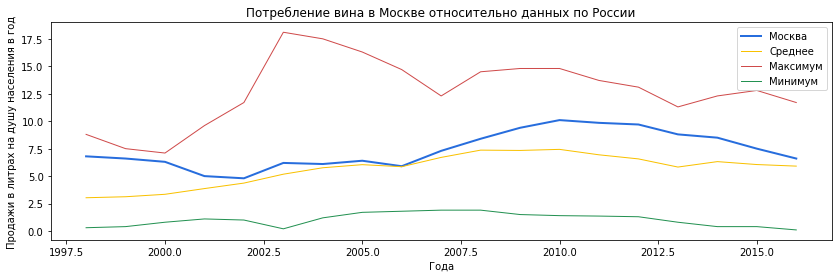

In [57]:
# Задаем данные по годам, в качестве оси X и данные по разным видам напитков по оси Y.
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(np_years, np_wine_region, '#276ddd', linewidth=2, label='Москва')
ax.plot(np_years, np_wine_mean, '#f9c100', linewidth=1, label='Среднее')
ax.plot(np_years, np_wine_max, '#cf4a4a', linewidth=1, label='Максимум')
ax.plot(np_years, np_wine_min, '#239151', linewidth=1, label='Минимум')

ax.set_title('Потребление вина в Москве относительно данных по России')
ax.set_xlabel('Года')
ax.set_ylabel('Продажи в литрах на душу населения в год')
ax.legend()
 
plt.show()

In [58]:
wine_rus_region = pd.pivot_table(df_rus_region, values='wine', index='region', columns='year', aggfunc='sum')
wine_rus_region.sort_values(by='region', ascending=False)

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Moscow,6.80000,6.600000,6.30000,5.000000,4.800000,6.200000,6.100000,6.400000,5.90000,7.300000,8.400000,9.400000,10.100000,9.850000,9.700000,8.800000,8.500000,7.500000,6.600000
Min,0.30000,0.400000,0.80000,1.100000,1.000000,0.200000,1.200000,1.700000,1.80000,1.900000,1.900000,1.500000,1.400000,1.360000,1.300000,0.800000,0.400000,0.400000,0.100000
Mean,3.02963,3.120988,3.34321,3.864198,4.364198,5.174074,5.760494,6.041975,5.85679,6.703704,7.365432,7.337037,7.434568,6.939259,6.566667,5.824691,6.319277,6.053012,5.909639
Max,8.80000,7.500000,7.10000,9.600000,11.700000,18.100000,17.500000,16.300000,14.70000,12.300000,14.500000,14.800000,14.800000,13.710000,13.100000,11.300000,12.300000,12.800000,11.700000


На протяжении большей части времени данные по Москве близки к средним значениям по России, но всегда чуть выше среднего. И максимально приблизилось к среднему значению в 2006 году. Москва - 5.9 литров вина, в среднем по России - 5.8 литров вина на душу неселения.

В 1998-1999 годах потребления вина в Москве было на одном из максимальных уровнея для России, но далее начало снижаться.В 1998 году в Москве выпили 6.8 литров вина, при этом максимальное потребление по России составляло 8.8 литров.

В 2003 году в России был резкий скачок в потреблении вина с 11.7 до 18.1 литра в год на максимальных значениях. При этом среднее значение выросло не так критично: с 4.3 до 5.2 литра. Что означает, что резкий всплеск был вызвон ростом потребления вина в одном или нескольких регионах страны. 

Пик потребления вина в Москве пришелся на 2010 год, когда потребление составило 10.1 литров вина на душу населения. 

После 2010 года потребления вина в столице постепенно снижалось и достигло 6.6 литров к 2016 году.

**Динамика потребления пива в заданном регионе относительно России**

In [59]:
#nampy array для оси Х со списком лет будем использовать из ранее созданного
#np_years

#Создаю nampy array для оси Y со списками значений для региона и средних, макс. и мин. данных по России
np_beer_region = np.array(df_region['beer'])
np_beer_max = np.array(df_max['beer'])
np_beer_min = np.array(df_min['beer'])
#Массив со средними значениями у нас уже был создан ранее
#np_beer_mean

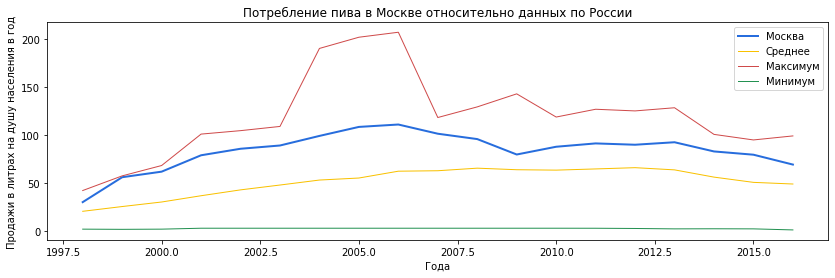

In [60]:
# Задаем данные по годам, в качестве оси X и данные по разным видам напитков по оси Y.
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(np_years, np_beer_region, '#276ddd', linewidth=2, label='Москва')
ax.plot(np_years, np_beer_mean, '#f9c100', linewidth=1, label='Среднее')
ax.plot(np_years, np_beer_max, '#cf4a4a', linewidth=1, label='Максимум')
ax.plot(np_years, np_beer_min, '#239151', linewidth=1, label='Минимум')

ax.set_title('Потребление пива в Москве относительно данных по России')
ax.set_xlabel('Года')
ax.set_ylabel('Продажи в литрах на душу населения в год')
ax.legend()
 
plt.show()

In [61]:
beer_rus_region = pd.pivot_table(df_rus_region, values='beer', index='region', columns='year', aggfunc='sum')
beer_rus_region.sort_values(by='region', ascending=False)

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Moscow,30.000000,56.000000,61.800000,78.900000,85.700000,89.100000,99.100000,108.500000,111.000000,101.400000,95.800000,79.700000,87.800000,91.280000,89.900000,92.500000,82.900000,79.500000,69.200000
Min,1.800000,1.600000,1.800000,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.740000,2.500000,2.100000,2.200000,2.100000,1.000000
Mean,20.419753,25.395062,30.130864,36.675309,42.791358,47.849383,53.045679,55.160494,62.285185,62.764198,65.445679,63.820988,63.393827,64.642593,65.960494,63.665432,56.110714,50.629762,48.911905
Max,42.100000,57.400000,68.200000,101.000000,104.600000,109.000000,190.400000,202.100000,207.300000,118.300000,129.400000,143.000000,118.800000,126.930000,125.200000,128.500000,100.700000,94.900000,99.100000


В Москве употребление пива на протяжении всего отчетного периода было выше, чем в среднем по стране.

В 1999 году потребление пива вплотную приблизилось к максимальному значению: 56 литров в Москве относительно 57.4 литра в целом по России.

В России был резкий всплеск потребления пива в 2004-2006 годах с 109 литров в 2003 году до 190 литров в 2004. Далее несколько лет сохранялось высокое потребление пива - 190-207 литров в год на душу населения. После которого был резкий спад до 118 литров в 2007 году и постепенное снижение до 99.1 литра в к 2016 году.

График потребления пива в Москве выглядит более гладким, общие тренды сохраняются, но без резких скачков. Пик потребления приходится также на 2005-2006 года - 108-111 литров на душу населения в год. К 2016 году потребление сократилось до 69.2 литров в год на человека.

**Динамика потребления водки в заданном регионе относительно России**

In [62]:
#nampy array для оси Х со списком лет будем использовать из ранее созданного
#np_years

#Создаю nampy array для оси Y со списками значений для региона и средних, макс. и мин. данных по России
np_vodka_region = np.array(df_region['vodka'])
np_vodka_max = np.array(df_max['vodka'])
np_vodka_min = np.array(df_min['vodka'])
#Массив со средними значениями у нас уже был создан ранее
#np_vodka_mean

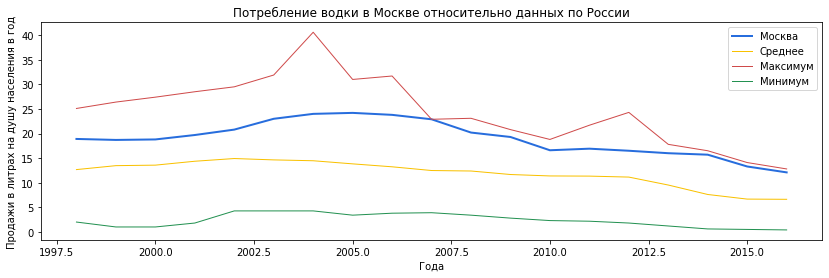

In [63]:
# Задаем данные по годам, в качестве оси X и данные по разным видам напитков по оси Y.
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(np_years, np_vodka_region, '#276ddd', linewidth=2, label='Москва')
ax.plot(np_years, np_vodka_mean, '#f9c100', linewidth=1, label='Среднее')
ax.plot(np_years, np_vodka_max, '#cf4a4a', linewidth=1, label='Максимум')
ax.plot(np_years, np_vodka_min, '#239151', linewidth=1, label='Минимум')

ax.set_title('Потребление водки в Москве относительно данных по России')
ax.set_xlabel('Года')
ax.set_ylabel('Продажи в литрах на душу населения в год')
ax.legend()
 
plt.show()

In [64]:
vodka_rus_region = pd.pivot_table(df_rus_region, values='vodka', index='region', columns='year', aggfunc='sum')
vodka_rus_region.sort_values(by='region', ascending=False)

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Moscow,18.900000,18.700000,18.80000,19.700000,20.800000,23.000000,24.000000,24.200000,23.800000,22.900000,20.200000,19.300000,16.600000,16.920000,16.500000,16.000000,15.700000,13.30000,12.100000
Min,2.000000,1.000000,1.00000,1.800000,4.266667,4.266667,4.266667,3.400000,3.800000,3.900000,3.400000,2.800000,2.300000,2.170000,1.800000,1.200000,0.600000,0.50000,0.400000
Mean,12.669136,13.469136,13.57284,14.365432,14.917284,14.640741,14.466667,13.833333,13.235802,12.479012,12.380247,11.667901,11.376543,11.341975,11.144444,9.528395,7.606024,6.66747,6.625301
Max,25.100000,26.400000,27.40000,28.500000,29.500000,31.900000,40.600000,31.000000,31.700000,22.900000,23.100000,20.800000,18.800000,21.690000,24.300000,17.800000,16.500000,14.10000,12.800000


Потребление водки в России росло с 1998 по 2004 годы, достигнув максимума в 31.9 литров на челоека в год. После 2004 года происходило стабильное снижение потребления и к 2016 году максимальный уровень потребления водки составил 12.8 литра, а среднее значение по России - 6.6 литра на человека в год.

В Москве потребление водки выше среднего по России.

В начале отчетного периода, в 1998 году в Москве потребление водки составило - 18.9 литров, при этом среднее значение по России было 12.6 литров, а максимальное 25.1 литр. 

Хотя в Москве прослеживается общий тренд на снижение потребления водки, но движение происходит медленнее, чем в других регионах страны. Таким образом уже в 2007 году Москва заняла первое место по употрблению водки - 22.9 литров.

После 2007 года Москва уступила первенство другим регионам, но потребление водки в регионе стабильно сохраняется на значениях близких к максимальным по стране и сильно выше средних значений.

С 2013 по 2016 года потребление водки в Москве максимально близко к максимальным значениям по России. Так в 2013 году в Москве выпито 16 литров водки на человека в год, среднее значение по стране составило 9.5 литров, а максимальное 17.8 литров, что незначительно больше Москвы.

В 2016 году максимальное потребление водки в России составило 12.8 литров на душу населения. Среднее значение - 6.6. литров, минимальное - 0.4. литра. Москва - 12.1 литра, что практически равно максимуму.

**Динамика потребления шампанского в заданном регионе относительно России**

In [65]:
#nampy array для оси Х со списком лет будем использовать из ранее созданного
#np_years

#Создаю nampy array для оси Y со списками значений для региона и средних, макс. и мин. данных по России
np_champagne_region = np.array(df_region['champagne'])
np_champagne_max = np.array(df_max['champagne'])
np_champagne_min = np.array(df_min['champagne'])
#Массив со средними значениями у нас уже был создан ранее
#np_champagne_mean

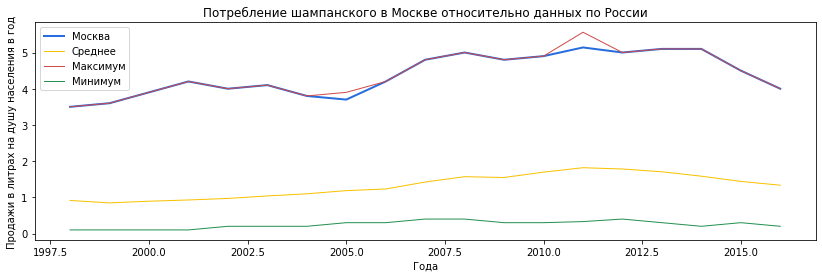

In [66]:
# Задаем данные по годам, в качестве оси X и данные по разным видам напитков по оси Y.
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(np_years, np_champagne_region, '#276ddd', linewidth=2, label='Москва')
ax.plot(np_years, np_champagne_mean, '#f9c100', linewidth=1, label='Среднее')
ax.plot(np_years, np_champagne_max, '#cf4a4a', linewidth=1, label='Максимум')
ax.plot(np_years, np_champagne_min, '#239151', linewidth=1, label='Минимум')

ax.set_title('Потребление шампанского в Москве относительно данных по России')
ax.set_xlabel('Года')
ax.set_ylabel('Продажи в литрах на душу населения в год')
ax.legend()
 
plt.show()

In [67]:
champagne_rus_region = pd.pivot_table(df_rus_region, values='champagne', index='region', columns='year', aggfunc='sum')
champagne_rus_region.sort_values(by='region', ascending=False)

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Moscow,3.50000,3.600000,3.900000,4.20000,4.000000,4.100000,3.800000,3.700000,4.200000,4.800000,5.00000,4.800000,4.900000,5.140000,5.000000,5.100000,5.100000,4.500000,4.00000
Min,0.10000,0.100000,0.100000,0.10000,0.200000,0.200000,0.200000,0.300000,0.300000,0.400000,0.40000,0.300000,0.300000,0.330000,0.400000,0.300000,0.200000,0.300000,0.20000
Mean,0.91358,0.846914,0.892593,0.92716,0.969136,1.038272,1.097531,1.185185,1.230864,1.422222,1.57037,1.548148,1.696296,1.817901,1.782716,1.706173,1.584337,1.439759,1.33494
Max,3.50000,3.600000,3.900000,4.20000,4.000000,4.100000,3.800000,3.900000,4.200000,4.800000,5.00000,4.800000,4.900000,5.560000,5.000000,5.100000,5.100000,4.500000,4.00000


Если посмотреть на график потребление шампанского, то можно сделать однозначный вывод о том, что Москва - лидер России по употреблению шампанского.

В течение всего отчетного периода с 1998 по 2016 года Москва занимала 1-е или одно из первых мест по употреблению шампанского.

В 1998 году максимальное потребление шампанского составило 3.5 литра на человека в год и это потребление Москвы. Москва оставалась лидером до 2004 года, когда потребление составило 3.8 литров в год. После чего на один год уступила пальму первенства.

Но с 2006 по 2016 год Москва стабильно была на первом месте по употреблению данного напитка. 

Хотя среднее потребление шампанского по России колебалось от 0.9 до 1.5 литров в год на человека, в Москве выпивалось от 3.5 до 5 литров шампанского в год.

В 2016 году среднее значение по России составило 1.3 литра, а в Москве - 4 литра шампанского в год на человека.

**Динамика потребления бренди в заданном регионе относительно России**

In [68]:
#nampy array для оси Х со списком лет будем использовать из ранее созданного
#np_years

#Создаю nampy array для оси Y со списками значений для региона и средних, макс. и мин. данных по России
np_brandy_region = np.array(df_region['brandy'])
np_brandy_max = np.array(df_max['brandy'])
np_brandy_min = np.array(df_min['brandy'])
#Массив со средними значениями у нас уже был создан ранее
#np_brandy_mean

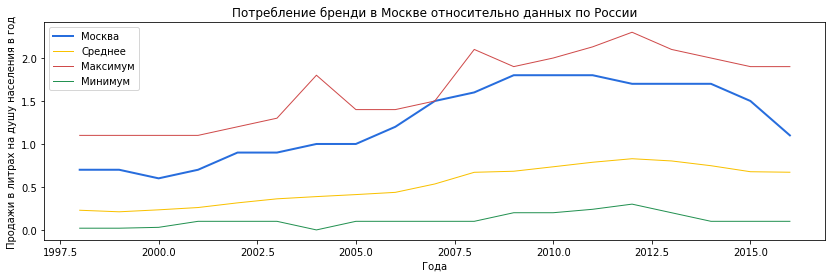

In [69]:
# Задаем данные по годам, в качестве оси X и данные по разным видам напитков по оси Y.
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(np_years, np_brandy_region, '#276ddd', linewidth=2, label='Москва')
ax.plot(np_years, np_brandy_mean, '#f9c100', linewidth=1, label='Среднее')
ax.plot(np_years, np_brandy_max, '#cf4a4a', linewidth=1, label='Максимум')
ax.plot(np_years, np_brandy_min, '#239151', linewidth=1, label='Минимум')

ax.set_title('Потребление бренди в Москве относительно данных по России')
ax.set_xlabel('Года')
ax.set_ylabel('Продажи в литрах на душу населения в год')
ax.legend()
 
plt.show()

In [70]:
brandy_rus_region = pd.pivot_table(df_rus_region, values='brandy', index='region', columns='year', aggfunc='sum')
brandy_rus_region.sort_values(by='region', ascending=False)

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Moscow,0.700000,0.700000,0.600000,0.700000,0.900000,0.900000,1.000000,1.000000,1.200000,1.500000,1.60000,1.800000,1.800000,1.800000,1.700000,1.700000,1.700000,1.500000,1.100000
Min,0.020000,0.020000,0.030000,0.100000,0.100000,0.100000,0.000000,0.100000,0.100000,0.100000,0.10000,0.200000,0.200000,0.240000,0.300000,0.200000,0.100000,0.100000,0.100000
Mean,0.228889,0.210864,0.233704,0.260494,0.314815,0.361728,0.387654,0.411111,0.437037,0.534568,0.67037,0.682716,0.734568,0.787284,0.828395,0.802469,0.746988,0.677108,0.671084
Max,1.100000,1.100000,1.100000,1.100000,1.200000,1.300000,1.800000,1.400000,1.400000,1.500000,2.10000,1.900000,2.000000,2.130000,2.300000,2.100000,2.000000,1.900000,1.900000


Потребление бренди в Москве на протяжении всего отчетного периода было выше средних значений по стране.

В 1998 году среднее значение составляло 0.2 литра на человека в год, а в Москве было выпито 0.7 литров. При этом максимальное значение для 1998 года было равно 1.1 литра.

Со временем потребление бренди в России стабильно росло. Рост прослеживается как по максимальным, так и по средним и минимальным значениям, но Москва всегда потребляла бренди выше среднего значения по стране, а в 2007 году даже заняла первое место со значением 1.5 литра на человека.

Пик потребления бренди в Москве приходится на 2009-2011 годы со значением 1.8 литров на человека. После чего пошел плавный спад, который достиг 1.1 литра на человека в 2016 году.

Всплеск потребления бренди в России при этом пришелся на 2012 год - 2.3 литра на человека. Среднее потребление по стране достигло своего максимума в 2012-2013 годах - 0.8 литра.



**Общие выводы по потреблению алкоголя в выбранном регионе**

1. Москва потребляет алкоголь больше, чем в среднем в России. 

2. С течением времени в Москве увеличивалось потребление всех типов алкогольных напитков, за исключением водки.

3. В категории вино и пиво Москва показала результаты выше средних по стране, но они находятся в промежутке от среднего к максимуму. В категориях же водки, шампанского и бренди Москва явно лидирует среди регионов России.

4. Потребление вина в Москве колебалось в заданный период, но в 1998 году составило 6.8, а в 2016 6.6 литров, то есть практически не изменилось. При этом среднее значение по России выросло с 3 до 6 литров, а максимальное выросло с 8.8 до 11.7 литров.

5. Потребление пива в Москве выросло с 30 литров в 1998 году до 69 литров в 2016 году. При этом общие тренды роста соответствуют средним по стране. Среднее потребление пива выросло с 42 до 99 литров за отчетный период.

6. Потребление водки в Москве снизилось с 18.9 до 12.1 литров за отчетный период. При этом среднее значение по стране в 1998 году составляло 12.6 литров, а в 2016 - 6.6. литров. Максимальные значения по России составили 25 литров в 1998 году и 12.8 в 2016 году. То есть к концу отчетного периода в Москве стали употреблять в 2 раза больше водки, чем в среднем по России и значение практически сровнялось с максимальным по стране.

7. Москва является лидером по употреблению шампанского на протяжении всего периода. В 1998 году было выпито 3.5 литров на человека в год. К 2016 объем составил 4 литра. Пик потребления шампанского пришелся на 2013-2014 годы, когда этого напитка было выпито 5.1 литров на человека в год.

8. В Москве также выше среднего и уровень потребления бренди. В 1998 году в Москве было выпито 0.7 литра на человека, при этом среднее значение по России составило 0.2 литра, а максимальное 1.1. литра. К 2016 году в Москве выпивали 1.1 литра бренди в год. При этом среднее значение по России составило 0.67 литра, а максимальное 1.9 литров.

9. Несмотря на лидирующие позиции Москвы в категориях шампанского и бренди, потребление этих напитков значительно отстает от потребления водки, что можем вызывать определенные опасения у руководства региона. Я рекомендую подробнее рассмотреть потребления водки в регионе и предусмотреть меры по его сокращению.